In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import os
import csv
import math
import random
import operator
import string
import logging
import re
import pandas as pd
import numpy as np
from numpy import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
root = '/content/gdrive/My Drive/ml project'
csv_path = os.path.join(root, 'hatespeech_text_abusive.xlsx')
df = pd.read_excel(csv_path, header = None)
df.rename(columns={0:'tweet', 1:'label'}, inplace=True)
print(df.head(10))

my_labels = ['hateful', 'normal']

                                               tweet    label
0  RT @Papapishu: Man it would fucking rule if we...  hateful
1  It is time to draw close to Him &#128591;&#127...   normal
2  if you notice me start to act different or dis...   normal
3  Forget unfollowers, I believe in growing. 7 ne...   normal
4  RT @Vitiligoprince: Hate Being sexually Frustr...  hateful
5  Topped the group in TGP Disc Jam Season 2! Ont...   normal
6  That daily baby aspirin for your #heart just m...   normal
7  I liked a @YouTube video from @mattshea https:...   normal
8  RT @LestuhGang_: If your fucking up &amp; your...  hateful
9  @Move_Fwd give up. You've lost. You will not c...   normal


In [4]:
def print_plot(index):
    example = df[df.index == index][['tweet', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])
print_plot(10)

RT @ennoia3: That's one way he pulls you in RT@amysreedusxx norman fucking reedus just threw candy at me when will your fav ever https://t.…
Label: hateful


In [5]:
import nltk
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')
STOPWORDS.append("rt")

WORDS = set(nltk.corpus.words.words())
WORDS.update({"fuck", "fucking"})

def clean_text():
    df["tweet"] = df["tweet"].apply(lambda x: x.lower())
    df["tweet"] = [re.sub('(@[^\s]+)|(#[^\s]+)', '', tweet) for tweet in df["tweet"]]
    df["tweet"] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) for tweet in df["tweet"]]
    df["tweet"] = [re.sub('(\'[^\s]+)|(&[^\s]+)','',tweet) for tweet in df["tweet"]]
    df["tweet"] = [re.sub('[^\w\s/:%.,_-]','',tweet) for tweet in df["tweet"]]
    df["tweet"] = df["tweet"].apply(lambda tweet: tweet.translate(str.maketrans('', '', string.punctuation)))
    df["tweet"] = df["tweet"].apply(lambda tweet: tweet.translate(str.maketrans('', '', "0123456789❤♀️♥⚽️《")) )
    df["tweet"] = df["tweet"].str.split(' ').apply(lambda tweet: ' '.join(k for k in tweet if k not in STOPWORDS))
    df["tweet"] = df["tweet"].str.split(' ').apply(lambda tweet: ' '.join(k for k in tweet if k in WORDS))
    df["tweet"] = df["tweet"].str.replace(' +', ' ', case=False)
    df["tweet"] = df["tweet"].str.strip()
    df["tweet"].replace('', np.nan, inplace=True)
    df.dropna(subset=["tweet"], inplace=True)
      
clean_text()
    
print(df.head(10))
len(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
                                               tweet    label
0     man would fucking rule party perpetual warfare  hateful
1            time draw close father draw near always   normal
2  notice start act different distant something n...   normal
3            forget believe growing new last day via   normal
4           hate sexually like fuck ion fuck anybody  hateful
5                  topped group disc jam season onto   normal
6                     daily baby aspirin might colon   normal
7             video blue army coming ancient warfare   normal
8                          fucking dont tell fucking  hateful
9        give lost convince one iota read conspiracy   normal


84865

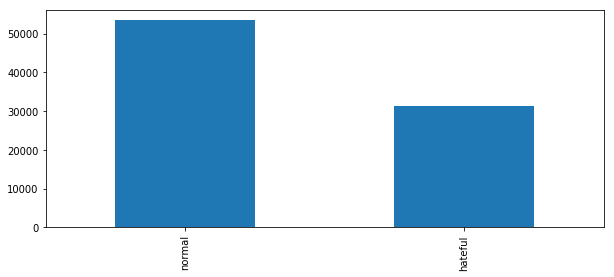

In [6]:
plt.figure(figsize=(10,4))
df.label.value_counts().plot(kind='bar');

In [7]:
from sklearn.model_selection import train_test_split

# Data splitting
X = df.tweet
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

print ('Total   tweet count:', len(df))
print ('Normal  tweet count:', len(df[df.label == "normal"]))
print ('Hateful tweet count:', len(df[df.label == "hateful"]), '\n')
print ('Total tweet count in trainin sampple:', len(X_train))
print ('Total tweet count in test sample:    ', len(X_test))
print ('Normal  tweet count in X_train:', X_train[y_train == "normal"].count())
print ('Hateful tweet count in X_train:', X_train[y_train == "hateful"].count())
print ('Normal  tweet count in X_test: ', X_test[y_test == "normal"].count())
print ('Hateful tweet count in X_test: ', X_test[y_test == "hateful"].count())

Total   tweet count: 84865
Normal  tweet count: 53440
Hateful tweet count: 31425 

Total tweet count in trainin sampple: 59405
Total tweet count in test sample:     25460
Normal  tweet count in X_train: 37383
Hateful tweet count in X_train: 22022
Normal  tweet count in X_test:  16057
Hateful tweet count in X_test:  9403


In [29]:
cv = CountVectorizer()
tfidftrans = TfidfTransformer()
after_cv = cv.fit_transform(X_train)
after_tf = tfidftrans.fit_transform(after_cv)
print(after_tf.shape)

(59405, 16016)


In [8]:
# Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [9]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8714454045561665
              precision    recall  f1-score   support

     hateful       0.88      0.76      0.81      9403
      normal       0.87      0.94      0.90     16057

   micro avg       0.87      0.87      0.87     25460
   macro avg       0.87      0.85      0.86     25460
weighted avg       0.87      0.87      0.87     25460

CPU times: user 713 ms, sys: 1.91 ms, total: 714 ms
Wall time: 714 ms


In [10]:
# Linear Support Vector Machine
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [11]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8553809897879026
              precision    recall  f1-score   support

     hateful       0.96      0.63      0.76      9403
      normal       0.82      0.99      0.90     16057

   micro avg       0.86      0.86      0.86     25460
   macro avg       0.89      0.81      0.83     25460
weighted avg       0.87      0.86      0.85     25460

CPU times: user 700 ms, sys: 0 ns, total: 700 ms
Wall time: 700 ms


In [12]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [13]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8515318146111548
              precision    recall  f1-score   support

     hateful       0.81      0.78      0.79      9403
      normal       0.87      0.90      0.88     16057

   micro avg       0.85      0.85      0.85     25460
   macro avg       0.84      0.84      0.84     25460
weighted avg       0.85      0.85      0.85     25460

CPU times: user 767 ms, sys: 2.96 ms, total: 770 ms
Wall time: 773 ms


In [14]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3)),
               ])
knn.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ki',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'))])

In [15]:
%%time

y_pred = knn.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.7993322859387274
              precision    recall  f1-score   support

     hateful       0.83      0.58      0.68      9403
      normal       0.79      0.93      0.85     16057

   micro avg       0.80      0.80      0.80     25460
   macro avg       0.81      0.75      0.77     25460
weighted avg       0.80      0.80      0.79     25460

CPU times: user 24.8 s, sys: 1.93 s, total: 26.8 s
Wall time: 26.8 s


In [16]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', DecisionTreeClassifier()),
              ])
dt.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [17]:
%%time
from sklearn.metrics import classification_report
y_pred = dt.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8720345640219953
              precision    recall  f1-score   support

     hateful       0.83      0.83      0.83      9403
      normal       0.90      0.90      0.90     16057

   micro avg       0.87      0.87      0.87     25460
   macro avg       0.86      0.86      0.86     25460
weighted avg       0.87      0.87      0.87     25460

CPU times: user 874 ms, sys: 2.01 ms, total: 876 ms
Wall time: 874 ms


In [18]:
# Random Forest  Classifier
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier()),
              ])
rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [19]:
%%time
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8989395129615082
              precision    recall  f1-score   support

     hateful       0.88      0.84      0.86      9403
      normal       0.91      0.93      0.92     16057

   micro avg       0.90      0.90      0.90     25460
   macro avg       0.89      0.89      0.89     25460
weighted avg       0.90      0.90      0.90     25460

CPU times: user 1.33 s, sys: 5.03 ms, total: 1.33 s
Wall time: 1.33 s


In [20]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', GradientBoostingClassifier()),
              ])
gb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [21]:
%%time
from sklearn.metrics import classification_report
y_pred = gb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8732914375490967
              precision    recall  f1-score   support

     hateful       0.95      0.69      0.80      9403
      normal       0.84      0.98      0.91     16057

   micro avg       0.87      0.87      0.87     25460
   macro avg       0.90      0.84      0.85     25460
weighted avg       0.88      0.87      0.87     25460

CPU times: user 807 ms, sys: 2.95 ms, total: 810 ms
Wall time: 813 ms


In [22]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier

xgb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [23]:
%%time
from sklearn.metrics import classification_report
y_pred = xgb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8692851531814612
              precision    recall  f1-score   support

     hateful       0.96      0.68      0.79      9403
      normal       0.84      0.98      0.90     16057

   micro avg       0.87      0.87      0.87     25460
   macro avg       0.90      0.83      0.85     25460
weighted avg       0.88      0.87      0.86     25460

CPU times: user 868 ms, sys: 0 ns, total: 868 ms
Wall time: 867 ms
